In this demo, we go over very few basic features of the `torch.nn` and the `torch.optim` modules offerd by PyTorch.

---

We present a manually developed class for creating _Fully Connected Neural Networks_ (called here `FCNN`), with a simple API (interface). For example, to create a fully connected neural network with 5 input features, 10 output features and hidden layers of sizes 32, 64, 32 in that order, we simply create an instance of the `FCNN` class as follows:

`FCNN(5, 32, 64, 32, 10, activation=CustomAct())`

where the last term `activation` is an optional keyword argument to specify arbitraty activation functions, as illustrated in this demo.

---

We also show a simple example of how to update the initial network parameters (i.e. to train your net) to fit a user-defined dataset using PyTorch's built-in optimizers.

---

Supplementary demo using desmos.com [here](https://www.desmos.com/calculator/qndc2o4dwu) where you can use your mouse to drag and train weights and biases of a simple 2-neuron network.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Single layer network

Let's create a function which maps from 1D features to 4D, and let's specify that changes in output are linearly dependent on changes in input.

The `nn.Linear` class is ideal for our purpose.

In [2]:
layer = nn.Linear(1, 4)

print('Weights:')
print(layer.weight.data)

print('Biases:')
print(layer.bias.data)

Weights:
tensor([[ 0.6261],
        [-0.4460],
        [-0.2022],
        [-0.4100]])
Biases:
tensor([ 0.8722, -0.0814, -0.0983, -0.6024])


---
To test the functionality of this `layer` object, we create a batch of 1D inputs of length 100. That is, each of the 100 items in this batch is a 1D 'tensor'.

In the cell below, the reason we reshape to size $100\times1$ is because `nn` modules follow the multiplication convention shown in the equation below ($xW^T$ not $Wx$), and the rule of thumb is to resize your data so that it's size looks like `(batch_size, feature_size)`. For example, if you wanted to created a 30-item batch of 4D features, the standard way to represent this would be in a $30\times4$ tensor, and calling `your_data.shape` should return `torch.Size([30, 4])`.

In [3]:
x = torch.linspace(-4, 4, 100).reshape(-1, 1)
x.shape

torch.Size([100, 1])

`y = layer(x)` is equivalent to $y = xW^T + b$

Dimensions of data:
\begin{alignat}{2}
 x: &&~ 100 &\times 1 \\
 W: &&~ 4 &\times 1 \\
 b: &&~ 1 &\times 4 \\
 y: &&~ 100 &\times 4
\end{alignat}

---
Graph model of one layer:

<img src="Linear.png" alt="drawing" width="300"/>

In [4]:
y = layer(x)

# Sample the first batch item (index 0) from output y
print('Raw sample of y:\n', y[0], '\n')

Raw sample of y:
 tensor([-1.6324,  1.7024,  0.7106,  1.0376], grad_fn=<SelectBackward>) 



---
---

### DETOUR: detaching a tensor from a graph

Below, we show one interesting difference to remember between variables that are 'attached to the graph' (like `y`) and variables that are not (like `x`).

In [5]:
try:
    y.numpy()
    print("We can call numpy on y")
except:
    print("We cannot call numpy on y")
    
try:
    x.numpy()
    print("We can call numpy on x")
except:
    print("We cannot call numpy on x")

We cannot call numpy on y
We can call numpy on x


As seen from the trials above, the `.numpy()` method cannot be called on `y`. The consequence of this is that we cannot plot `y` using matplotlib, since matplotlib relies on converting it first to a numpy array. Luckily, there are two fixes (and they are standard practice, not my invention), and they're presented below.

In [6]:
# Approach 1: use "detach"
try:
    y.detach().numpy()
    print("We can call numpy on y.detach()")
except:
    print("We cannot call numpy on y.detach()")

# Approach 2: use the 'no_grad' context manager
try:
    with torch.no_grad():
        y.numpy()
    print("We can call numpy on y using the 'no_grad' context manager")
except:
    print("We cannot call numpy on y using the 'no_grad' context manager")

We can call numpy on y.detach()
We can call numpy on y using the 'no_grad' context manager


As seen above, we are indeed able to convert `y` to a numpy array, and below is a prove that the original `y` that's 'attached to the graph' is still there unaffected.

In [7]:
y[0]

tensor([-1.6324,  1.7024,  0.7106,  1.0376], grad_fn=<SelectBackward>)

### END OF DETOUR

---
---

Plot output of single layer which maps 1D to 4D

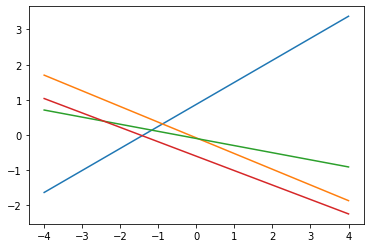

In [8]:
plt.plot(x, y.detach())
plt.show()

`y = activation(layer(x))` is equivalent to $y = \sigma(xW^T + b)$

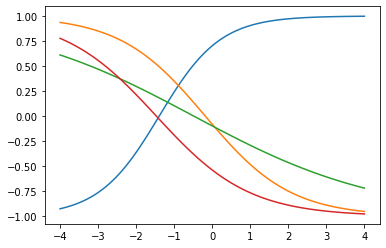

In [9]:
activation = nn.Tanh()

y = activation(layer(x))

plt.plot(x, y.detach())
plt.show()

# Custom Activation functions

In [10]:
class CustomAct(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return torch.exp(-x**2)

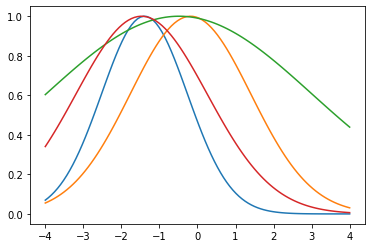

In [11]:
activation = CustomAct()

y = activation(layer(x))

plt.plot(x, y.detach())
plt.show()

# Multi-layer network
Just like the activation function above, any nueral network model created using PyTorch inherits from the `nn.Module` class. For more about this base class, [click here](https://pytorch.org/docs/stable/generated/torch.nn.Module.html).

Below, we create a general-use-case fully connected network class by taking advantage of the `nn.Sequential` class. Before doing so, here's a simple example of using this Sequential class.

In [12]:
nn.Sequential(nn.Linear(1, 4), nn.ReLU(), nn.Linear(4, 8))

Sequential(
  (0): Linear(in_features=1, out_features=4, bias=True)
  (1): ReLU()
  (2): Linear(in_features=4, out_features=8, bias=True)
)

Sequential(
  (0): Linear(in_features=1, out_features=16, bias=True)
  (1): CustomAct()
  (2): Linear(in_features=16, out_features=32, bias=True)
  (3): CustomAct()
  (4): Linear(in_features=32, out_features=16, bias=True)
  (5): CustomAct()
  (6): Linear(in_features=16, out_features=1, bias=True)
)


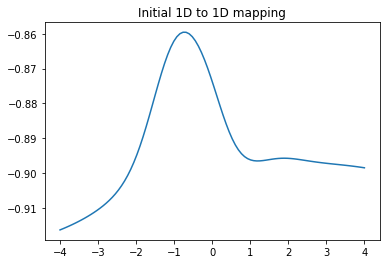

In [13]:
class FCNN(nn.Module):
    '''
    "FCNN" = "Fully Connected Neural Network"
    
    Creates a fully connected neural network based on a sequence of arguments,
    each being the number of neurons in each layer, ordered from input to
    output. The keyword argument 'activation' is used to specify the activation
    function used in between layers. The activation function is assumed to be
    inhereted from the nn.Module base class.
    
    '''
    def __init__(self, *neurons, activation=nn.ReLU()):
        super().__init__()
        self.neurons = neurons
        assert len(neurons) > 1, 'Network requires at least 2 layers (input & output)'
        layers = []
        for n_in, n_out in zip(neurons[:-1], neurons[1:]):
            layers.append(nn.Linear(n_in, n_out))
            layers.append(activation)
        layers.pop(-1) # exclude activation from output layer
        self.net = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.net(x)
    
multi_layer = FCNN(1, 16, 32, 16, 1, activation=CustomAct())
print(multi_layer.net)

y = multi_layer(x)

plt.title('Initial 1D to 1D mapping')
plt.plot(x, y.detach())
plt.show()

# Optimizer

Using the `torch.optim` module, we will update the initial set of parameters in our `multi_layer.net` so that the output of our network better fits a user-defined output profile

### Define your training data

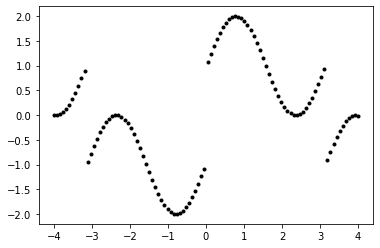

In [14]:
y_user_defined = torch.sin(2 * x) + x.sin().sign()

plt.plot(x, y_user_defined.detach(), 'k.')
plt.show()

### Simplest possible form of training
All the lines of code in the cell below are **the skeleton of any PyTorch-based implementation**, you'll see those everywhere, but more details need to be added for more interesting problems.

For example, we don't split our data, we don't train in batches, we don't regularize by penalizing weights, we don't monitor loss, to list a few.

In [15]:
import torch.optim as optim

optimizer = optim.Adam(multi_layer.net.parameters(), lr=0.01)
criterion = nn.MSELoss()

for _ in range(1000):
    
    yhat = multi_layer.net(x)
    loss = criterion(yhat, y_user_defined)

    # PyTorch magic!
    optimizer.zero_grad()   # Initialize gradients to zero again
    loss.backward()         # Backpropagation computes and stores gradient of loss w.r.t. net parameters
    optimizer.step()        # Update weights & biases by performing some form of gradient descent

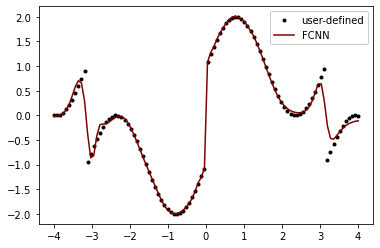

In [16]:
y = multi_layer(x)

plt.plot(x, y_user_defined.detach(), 'k.', label='user-defined')
plt.plot(x, y.detach(), 'maroon', label='FCNN')
plt.legend(framealpha=1.0)
plt.show()

# CHALLENGE TO STUDENT

The simple example above didn't require any consideration to hyperparameter tuning.

Can you construct a counter-example, where you have more sophisticated $(x,y)$ pairs that do not perform well under the current approach adopted above? If so, what fixes would you make to improve your results?

Hint: Come up with a list of factors (hyperparameters) that could influence the performance, and try to hunt somehow for the optimal set of hyperparameters.